# Regrese 1

## Cvičení

### Vytvořte nelineární regresní model

1. Načtěte data `misrala` a `BoxBOD`. Vizualizujte datové sady pomocí bodového grafu.  
2. Vytvořte polynomiální a nelineární regresní modely.  
   Funkce nelineární regrese je definována jako:  
   `y = a(1 − e^(−bx)) + ε`  
   Porovnejte získané modely na základě kvalitativních kritérií.
3. Vizualizujte výsledky a uložte grafy jako soubory ve formátu PNG.


In [1]:
# Imports
import gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from scipy.optimize import curve_fit
import warnings
from scipy.optimize import OptimizeWarning

plt.style.use('default')
sns.set_style("whitegrid")

# File structure config
dataset_dir = Path("datasets")
dataset_dir.mkdir(exist_ok=True)
dataset_url = "https://drive.google.com/drive/folders/1hXRpUJKJRl4DhuprUaQMXWuXPwx69yy0"
plots_dir = Path("plots")
plots_dir.mkdir(exist_ok=True)

if not dataset_dir.exists():
    gdown.download_folder(url=dataset_url, output=str(dataset_dir), use_cookies=False)

files = {
    "boxbod": {
        "filename": "BoxBOD.txt",
        "sep": r"\s+",
        "quotechar": '"',
        "engine": "python",
        "skiprows": 1,
        "names": ["id", "x", "y"],
        "x_col": "x",
        "y_col": "y"
    },
    "misrala": {
        "filename": "misrala.txt",
        "sep": r"\s+",
        "quotechar": '"',
        "engine": "python",
        "skiprows": 1,
        "names": ["id", "x", "y"],
        "x_col": "x",
        "y_col": "y"
    }
}

# dataframes dict for reuse
dataframes = {}

for name, props in files.items():
    path = dataset_dir / props["filename"]
    try:
        df = pd.read_csv(path, sep=props["sep"], quotechar=props["quotechar"], engine=props["engine"], skiprows=props["skiprows"], names=props["names"])
        dataframes[name] = {
            "df": df,
            "x_col": props["x_col"],
            "y_col": props["y_col"]
        }
        print(f"\n=== {name.upper()} ===")
        df.info()
        print(df.describe())
    except FileNotFoundError:
        print(f"File not found {path}")
    except pd.errors.ParserError as e:
        print(f"Parsing error in file {path}: {e}")


=== BOXBOD ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      6 non-null      object
 1   x       6 non-null      int64 
 2   y       6 non-null      int64 
dtypes: int64(2), object(1)
memory usage: 276.0+ bytes
               x           y
count   6.000000    6.000000
mean    4.666667  170.333333
std     3.386247   42.902991
min     1.000000  106.000000
25%     2.250000  149.000000
50%     4.000000  170.000000
75%     6.500000  207.500000
max    10.000000  214.000000

=== MISRALA ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      14 non-null     object 
 1   x       14 non-null     float64
 2   y       14 non-null     float64
dtypes: float64(2), object(1)
memory usage: 468.0+ bytes
                x          

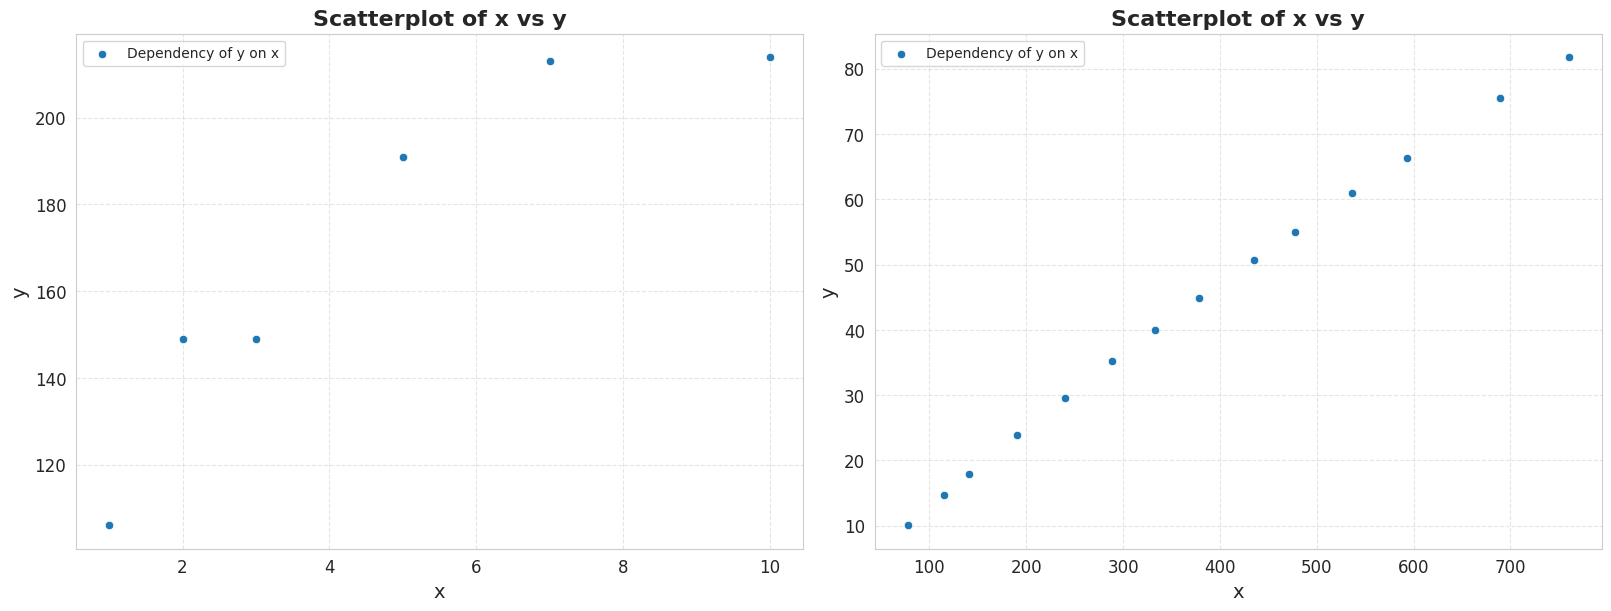

In [2]:
plot_configs = []

for name, info in dataframes.items():
    plot_configs.append({
        "data": info["df"],
        "x": info["x_col"],
        "y": info["y_col"],
        "title": f"Scatterplot of {info['x_col']} vs {info['y_col']}",
        "label": f"Dependency of {info['y_col']} on {info['x_col']}"
    })

fig, axes = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)

for ax, cfg in zip(axes, plot_configs):
    sns.scatterplot(data=cfg["data"], x=cfg["x"], y=cfg["y"], ax=ax, label=cfg["label"])
    ax.set_title(cfg["title"], fontsize=16, fontweight='bold')
    ax.set_xlabel(cfg["x"], fontsize=14)
    ax.set_ylabel(cfg["y"], fontsize=14)
    ax.tick_params(axis='both', labelsize=12)
    ax.grid(True, linestyle='--', alpha=0.5)

fig.savefig(plots_dir / "combined_scatterplots.png", dpi=300)
plt.show()

In [3]:
def non_linear_func(x, a, b):
    return a * (1 - np.exp(-b * x))

def run_regressions(df, x_col, y_col, test_size=0.3, random_state=42, max_poly_degree=10):
    X = df[[x_col]].values
    y = df[y_col].values

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # --- Non-linear Regression ---
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", OptimizeWarning)
        try:
            popt, _ = curve_fit(non_linear_func, X_train.flatten(), y_train, p0=(max(y_train), 0.01), maxfev=10000)
            y_pred_nl = non_linear_func(X_test.flatten(), *popt)

            nl_metrics = {
                "MSE": mean_squared_error(y_test, y_pred_nl),
                "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_nl)),
                "MAE": mean_absolute_error(y_test, y_pred_nl),
                "R2": r2_score(y_test, y_pred_nl),
                "params": popt
            }
        except RuntimeError:
            nl_metrics = {
                "MSE": np.nan,
                "RMSE": np.nan,
                "MAE": np.nan,
                "R2": np.nan,
                "params": (np.nan, np.nan)
            }

    # --- Polynomial Regression ---
    poly_results = []

    for degree in range(2, max_poly_degree + 1):
        poly = PolynomialFeatures(degree=degree)
        X_poly_train = poly.fit_transform(X_train)
        X_poly_test = poly.transform(X_test)

        model = LinearRegression()
        model.fit(X_poly_train, y_train)
        y_pred = model.predict(X_poly_test)

        metrics = {
            "MSE": mean_squared_error(y_test, y_pred),
            "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
            "MAE": mean_absolute_error(y_test, y_pred),
            "R2": r2_score(y_test, y_pred)
        }

        poly_results.append({
            "degree": degree,
            "model": model,
            "transformer": poly,
            "metrics": metrics
        })

    best_poly = min(poly_results, key=lambda r: r["metrics"]["MSE"])
    return nl_metrics, poly_results, best_poly

In [4]:
for name, info in dataframes.items():
    df = info["df"]
    x_col = info["x_col"]
    y_col = info["y_col"]

    nl_metrics, poly_results, best_poly = run_regressions(df, x_col, y_col)

    print(f"\n[{name.upper()}] Non-linear Regression:")
    print(f"  MSE: {nl_metrics['MSE']:.3f}, RMSE: {nl_metrics['RMSE']:.3f}, "
          f"MAE: {nl_metrics['MAE']:.3f}, R2: {nl_metrics['R2']:.3f}")
    print(f"  Parameters (a, b): {nl_metrics['params']}")

    print(f"\n[{name.upper()}] Polynomial Regression (per degree):")
    for result in poly_results:
        deg = result["degree"]
        m = result["metrics"]
        print(f"  Degree {deg} -> MSE: {m['MSE']:.3f}, RMSE: {m['RMSE']:.3f}, "
              f"MAE: {m['MAE']:.3f}, R2: {m['R2']:.3f}")

    best_deg = best_poly["degree"]
    best_m = best_poly["metrics"]
    print(f"\n[{name.upper()}] Best Polynomial Degree: {best_deg}")
    print(f"  MSE: {best_m['MSE']:.3f}, RMSE: {best_m['RMSE']:.3f}, "
          f"MAE: {best_m['MAE']:.3f}, R2: {best_m['R2']:.3f}")


[BOXBOD] Non-linear Regression:
  MSE: 1091.148, RMSE: 33.033, MAE: 32.929, R2: -1.361
  Parameters (a, b): [223.35156388   0.37899088]

[BOXBOD] Polynomial Regression (per degree):
  Degree 2 -> MSE: 502.839, RMSE: 22.424, MAE: 21.738, R2: -0.088
  Degree 3 -> MSE: 660.259, RMSE: 25.696, MAE: 25.400, R2: -0.428
  Degree 4 -> MSE: 265.801, RMSE: 16.303, MAE: 12.011, R2: 0.425
  Degree 5 -> MSE: 290.200, RMSE: 17.035, MAE: 17.030, R2: 0.372
  Degree 6 -> MSE: 448.597, RMSE: 21.180, MAE: 19.530, R2: 0.030
  Degree 7 -> MSE: 600.930, RMSE: 24.514, MAE: 20.662, R2: -0.300
  Degree 8 -> MSE: 714.538, RMSE: 26.731, MAE: 21.150, R2: -0.546
  Degree 9 -> MSE: 791.730, RMSE: 28.138, MAE: 21.356, R2: -0.713
  Degree 10 -> MSE: 841.881, RMSE: 29.015, MAE: 21.441, R2: -0.821

[BOXBOD] Best Polynomial Degree: 4
  MSE: 265.801, RMSE: 16.303, MAE: 12.011, R2: 0.425

[MISRALA] Non-linear Regression:
  MSE: 0.011, RMSE: 0.106, MAE: 0.094, R2: 1.000
  Parameters (a, b): [2.39175750e+02 5.49772629e-04]


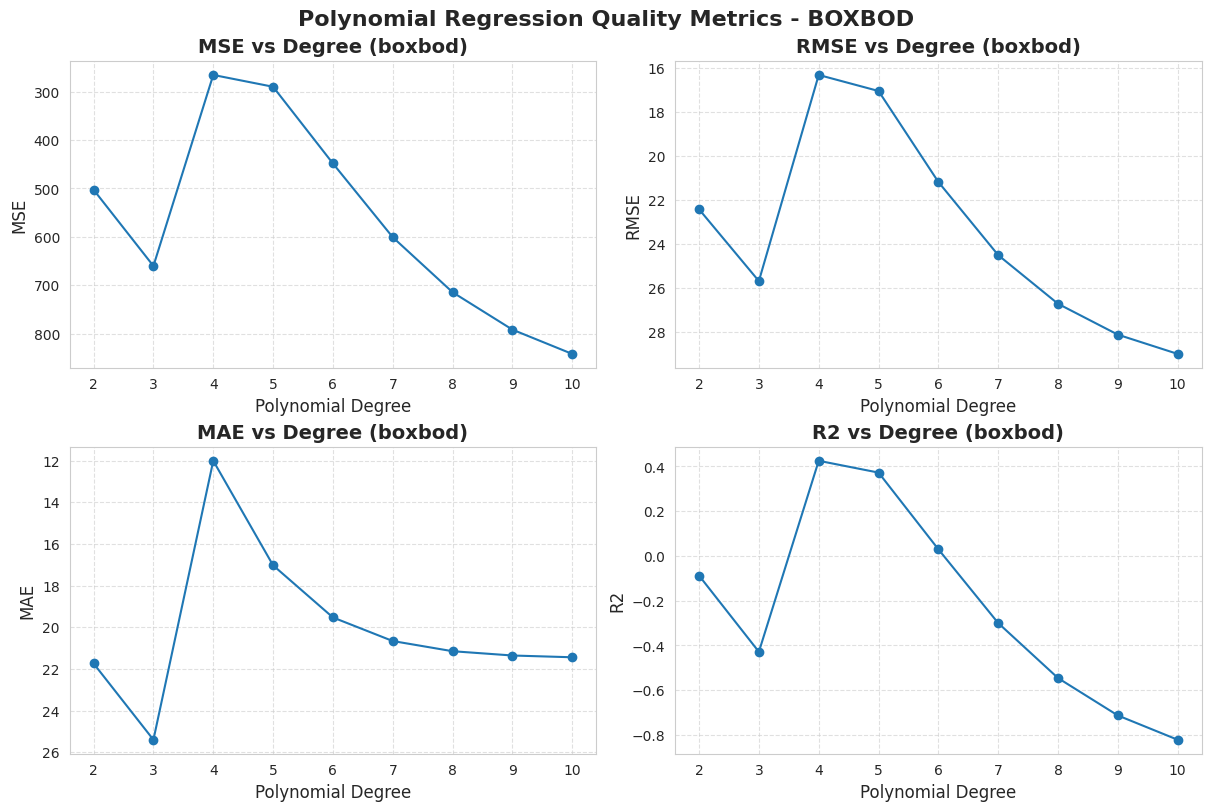

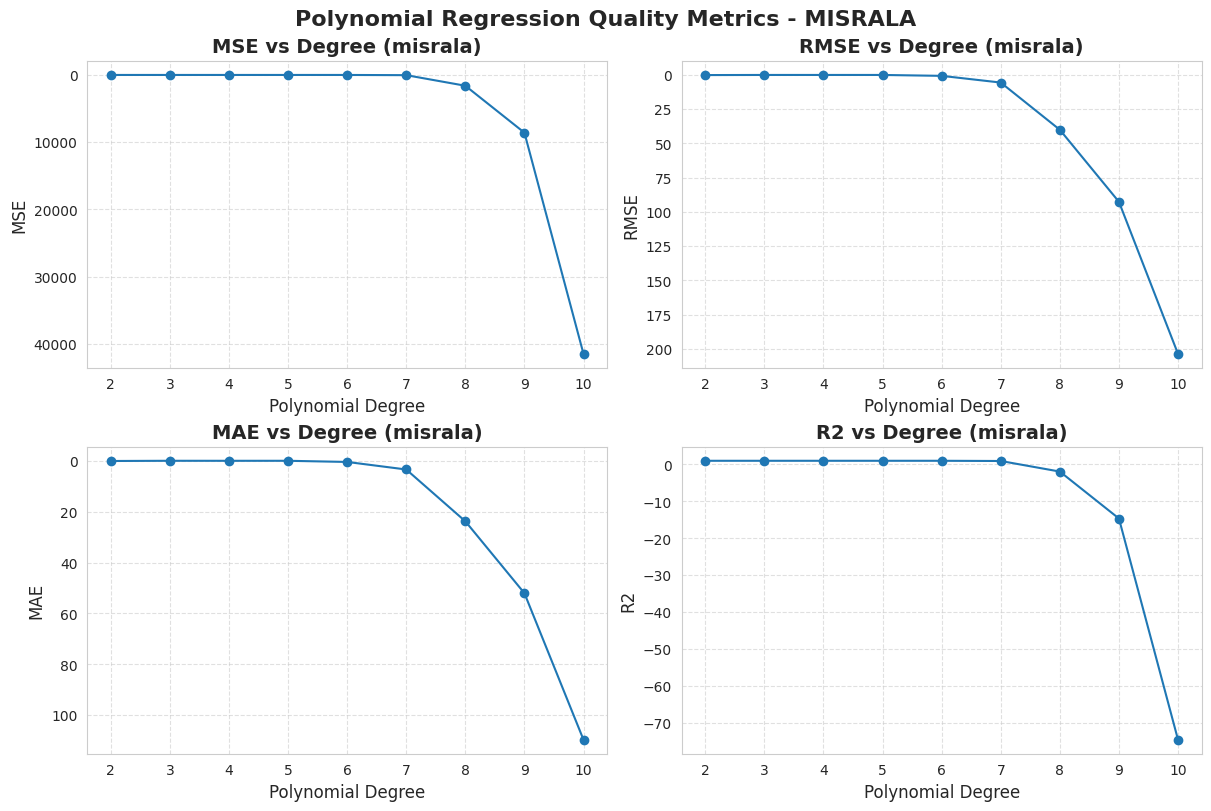

In [5]:
metrics_names = ["MSE", "RMSE", "MAE", "R2"]

for name, info in dataframes.items():
    df = info["df"]
    x_col = info["x_col"]
    y_col = info["y_col"]

    _, poly_results, _ = run_regressions(df, x_col, y_col)

    degrees = [res["degree"] for res in poly_results]
    mse_vals = [res["metrics"]["MSE"] for res in poly_results]
    rmse_vals = [res["metrics"]["RMSE"] for res in poly_results]
    mae_vals = [res["metrics"]["MAE"] for res in poly_results]
    r2_vals = [res["metrics"]["R2"] for res in poly_results]

    metric_values = [mse_vals, rmse_vals, mae_vals, r2_vals]

    fig, axes = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        ax.plot(degrees, metric_values[i], marker='o', linestyle='-')
        ax.set_xlabel("Polynomial Degree", fontsize=12)
        ax.set_ylabel(metrics_names[i], fontsize=12)
        ax.set_title(f"{metrics_names[i]} vs Degree ({name})", fontsize=14, fontweight='bold')
        ax.grid(True, linestyle='--', alpha=0.6)
        if metrics_names[i] != "R2":
            ax.invert_yaxis()

    plt.suptitle(f"Polynomial Regression Quality Metrics - {name.upper()}", fontsize=16, fontweight='bold')
    filename = f"quality_metrics_{name}.png"
    plt.savefig(plots_dir / filename, dpi=300)
    plt.show()

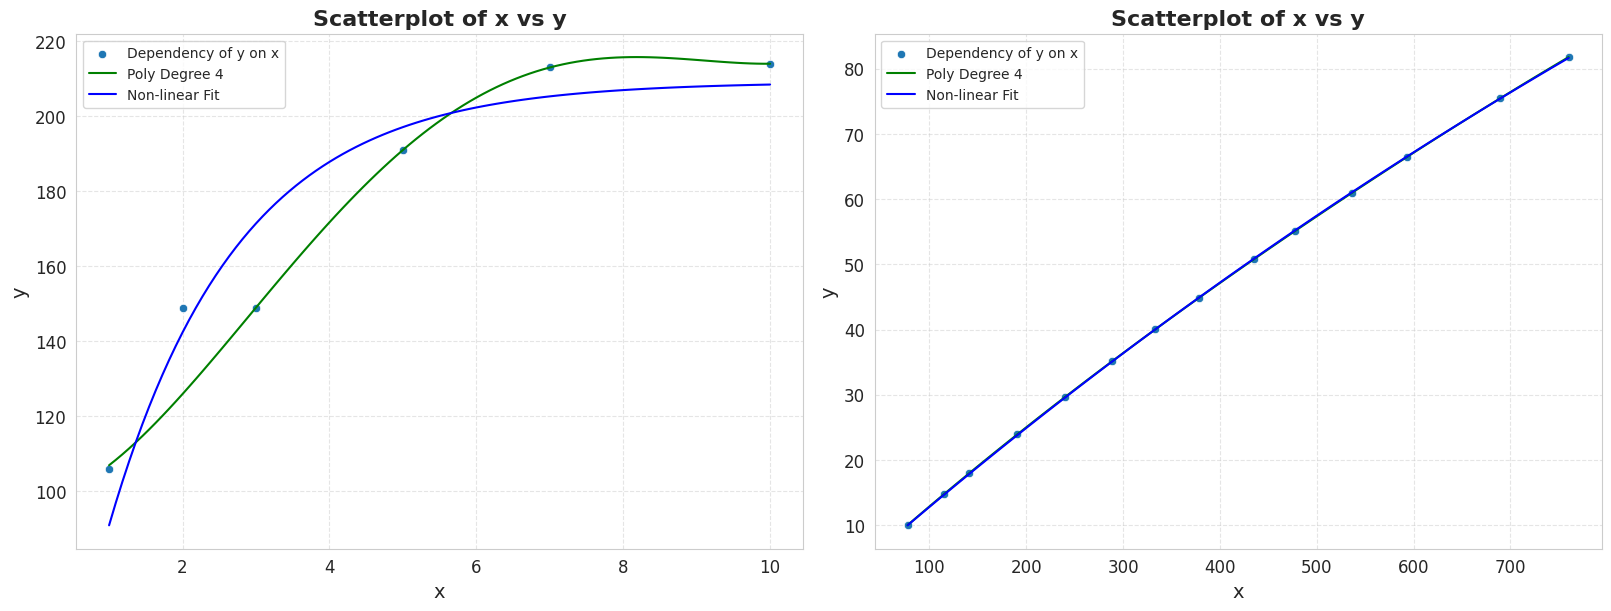

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)

for ax, cfg in zip(axes, plot_configs):
    df = cfg["data"]
    x_col = cfg["x"]
    y_col = cfg["y"]

    sns.scatterplot(data=df, x=x_col, y=y_col, ax=ax, label=cfg["label"])

    X_plot = np.linspace(df[x_col].min(), df[x_col].max(), 100).reshape(-1, 1)
    X = df[[x_col]].values
    y = df[y_col].values

    # Polynomial
    _, _, best_poly = run_regressions(df, x_col, y_col)
    poly = best_poly["transformer"]
    poly_model = best_poly["model"]

    X_poly_plot = poly.transform(X_plot)
    y_poly_pred = poly_model.predict(X_poly_plot)
    ax.plot(X_plot, y_poly_pred, color='green', label=f'Poly Degree {best_poly["degree"]}')

    # Non-linear
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", OptimizeWarning)
        try:
            popt, _ = curve_fit(non_linear_func, X.flatten(), y, p0=(max(y), 0.01), maxfev=10000)
            y_nl_pred = non_linear_func(X_plot.flatten(), *popt)
            ax.plot(X_plot, y_nl_pred, color='blue', label='Non-linear Fit')
        except RuntimeError:
            print(f"Non-linear fit failed for {cfg['title']}")


    ax.set_title(cfg["title"], fontsize=16, fontweight='bold')
    ax.set_xlabel(x_col, fontsize=14)
    ax.set_ylabel(y_col, fontsize=14)
    ax.tick_params(axis='both', labelsize=12)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend()

fig.savefig(plots_dir / "scatter_with_nonlinear_and_poly.png", dpi=300)
plt.show()